In [35]:
from uszipcode import SearchEngine
import networkx as nx
import pickle
import itertools
import random
from area import area
import math
import shapely.geometry as geometry
import folium as f
from scipy.spatial import ConvexHull


search = SearchEngine(simple_zipcode=False, db_file_dir="./zip_code_cache")

In [36]:
g = nx.read_gpickle("01_cambridge.gpickle")
nodes_data_subset = g.nodes().data()

## Populate dictionary of zip codes and node_ids.

### `zip_code_dict` and `nodes_by_zip` are inverses of each other

In [49]:
def get_zip_code_dict(g):
    count = 0
    with open('zip_code_dict.pickle', 'rb') as handle:
        zip_code_dict = pickle.load(handle)

    for node_data in g.nodes().data():
        count += 1
        node_id = node_data[1]["id"]
        lon,lat = node_data[1]['lon'], node_data[1]['lat']
        if node_id not in zip_code_dict:
            print("missing zip codes being added! This might take a while...")
            zip_code_dict[node_id] = search.by_coordinates(lat, lon, returns=1)[0].zipcode
        if count % 100 == 0: 
            with open('zip_code_dict.pickle', 'wb') as handle:
                pickle.dump(zip_code_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)        

    with open('zip_code_dict.pickle', 'wb') as handle:
        pickle.dump(zip_code_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return zip_code_dict

# Generate reverse dictionary——nodes by zip instaed of zips by node
def get_nodes_by_zip(zip_code_dict):
    nodes_by_zip = {}
    for node_id, zip_code in zip_code_dict.items():
        nodes_by_zip.setdefault(zip_code, []).append(node_id)
    return nodes_by_zip

def area_km2_from_map(g, zip_code):
    lat_lons = [[x[1]["lat"], x[1]["lon"]] for x in g.nodes().data() if x[0] in nodes_by_zip[zip_code]]
    if len(lat_lons) < 3:
        return .000000001
    hull = ConvexHull(lat_lons)
    hull_edges = [[hull.points[ix][1], hull.points[ix][0]] for ix in hull.vertices]
    polygon = {'type': 'Polygon', 'coordinates': [hull_edges]}
    return (area(polygon) / 1000000)


zip_code_dict = get_zip_code_dict(g)
nodes_by_zip = get_nodes_by_zip(zip_code_dict)

In [38]:
def semi_random_nodes(g, percentage):
    k = percentage * len(g)
    zips_in_g = {zip_code_dict[node_id] for node_id in g}
    
    weight_by_zip = {}
    for zip_code in zips_in_g:
        weight_by_zip[zip_code] = area_km2_from_map(g, zip_code) * search.by_zipcode(zip_code).population_density
    
    sum_of_weights = sum([v for k,v in weight_by_zip.items()])    
    set_of_nodes_g = set({node for node in g})
    
    num_by_zip = {}
    for zip_code in zips_in_g:
        absolute_num = math.ceil(weight_by_zip[zip_code]*k/sum_of_weights)
        nodes_in_zip_code = list(set(nodes_by_zip[zip_code]) & set_of_nodes_g)
        if absolute_num > len(nodes_in_zip_code):
            print(zip_code)
            print("absolute num:    " + str(absolute_num))
            print("number of nodes: " + str(len(nodes_in_zip_code)))
            area_from_points = (area_km2_from_map(g, zip_code))
            land_area = (search.by_zipcode(zip_code).land_area_in_sqmi * 2.58999)
            print(area_from_points / land_area)
            print("____")
        else: print("***" + str(absolute_num))
        num_by_zip[zip_code] = absolute_num
#     print("[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]")
#     for zip_code in zips_in_g:
#         nodes_in_zip_code = list(set(nodes_by_zip[zip_code]) & set_of_nodes_g)

#         print(zip_code)
#         print("number of nodes: " + str(len(nodes_in_zip_code)))
        
    return_nodes = {}
    for zip_code,num in num_by_zip.items():
        nodes_in_zip_code = list(set(nodes_by_zip[zip_code]) & set_of_nodes_g)
        if len(nodes_in_zip_code) > num:
            return_nodes[zip_code] = random.sample(nodes_in_zip_code, num)
        else:    
            return_nodes[zip_code] = nodes_in_zip_code
    

          
    return list(itertools.chain.from_iterable([nodes for zip_code,nodes in return_nodes.items()]))
aa = semi_random_nodes(g, 1)
print(len(aa)/ len(g))
## ISSUE HERE: why does it go down down down when the k value goes up?

02134
absolute num:    407
number of nodes: 247
0.27822140855329
____
***1183
02129
absolute num:    13
number of nodes: 4
0.011644602163902729
____
02114
absolute num:    223
number of nodes: 12
0.2735635608799142
____
***163
***1
02143
absolute num:    877
number of nodes: 716
0.5265648058449993
____
02139
absolute num:    1955
number of nodes: 1483
0.7908773651978571
____
02199
absolute num:    27
number of nodes: 5
0.32584511330113786
____
***407
***1
***1479
***1
02446
absolute num:    21
number of nodes: 5
0.010472155116296544
____
02116
absolute num:    450
number of nodes: 237
0.32129764300000047
____
***3
0.8257428492085532


## Use `area` library to find Polygon's geographic area

### First, simple PoC with Wyoming

In [39]:
wyoming = {'type':'Polygon','coordinates':[[[-111.046768, 40.997963], 
                                            [-111.055196, 45.001320], 
                                            [-104.057691, 44.997377],
                                            [-104.053251, 41.001410],
                                            [-111.046768, 40.997963]]]}

area_km2 = area(wyoming)

area_km2 = area_km2 / 1e+6
# print ('area m2: ' + str(math.floor(area_m2)))
print ('Estimated area of Wyoming: ' + str(math.floor(area_km2)) + 'km^2')
print("Error:                     " + str(253600 - math.floor(area_km2)) + "km^2" )

Estimated area of Wyoming: 253529km^2
Error:                     71km^2


### Now running on entire Cambridge dataset. (Note—outliers skew this)

In [40]:
from scipy.spatial import ConvexHull

lat_lons = [[x[1]["lat"], x[1]["lon"]] for x in g.nodes().data()]
hull = ConvexHull(lat_lons)
hull_edges = [[hull.points[ix][1], hull.points[ix][0]] for ix in hull.vertices]

camb = {'type': 'Polygon', 'coordinates': [hull_edges]}

print("Area of convex map: " + (str (area(camb) / 1000000)) + "km^2")



Area of convex map: 21.747622196450717km^2


In [41]:
# ZIP_CODE = '02139'

# lat_lons = [[x[1]["lat"], x[1]["lon"]] for x in g.nodes().data() if x[0] in nodes_by_zip[ZIP_CODE]]
# hull = ConvexHull(lat_lons)
# hull_edges = [[hull.points[ix][1], hull.points[ix][0]] for ix in hull.vertices]
# polygon = {'type': 'Polygon', 'coordinates': [hull_edges]}

# print("Area of convex map:        " + (str (area(polygon) / 1000000)) + "km^2")
# print("Actual land area of " + ZIP_CODE + ": " + str(search.by_zipcode(ZIP_CODE).land_area_in_sqmi * 2.58999) + "km^2")


# def weights_by_zip(g, zip_code):
    


    
    


In [42]:
m = f.Map(location = [42.3611108,-71.1079923], zoom_start=16)

# Show graph with hull edges
for node_data in g.nodes().data():
    node_id = node_data[1]["id"]
    if not node_data[1].get('lon'):
        import pdb; pdb.set_trace()
    lon,lat = node_data[1]['lon'], node_data[1]['lat']  
    if [lon, lat] in hull_edges:
        m.add_child(f.Marker(location=[lat,lon], color="red", radius=1))
    
    m.add_child(f.CircleMarker(location=[lat,lon], color="orange", radius=.5))

m

# Cruft Zone (-producing cruft. 

In [43]:
import pyproj    
import shapely
import shapely.ops as ops
from shapely.geometry.polygon import Polygon
from functools import partial


# geom = Polygon([[40.997963, -111.046768], 
#                 [45.001320, -111.055196], 
#                 [44.997377, -104.057691],
#                 [41.001410, -104.053251],
#                 [40.997963, -111.046768]])


geom = Polygon([[-111.046768, 40.997963], 
                [-111.055196, 45.001320], 
                [-104.057691, 44.997377],
                [-104.053251, 41.001410],
                [-111.046768, 40.997963]])
# geom = Polygon([[40,-111],
#                 [2,3],
#                 [3,5],
#                 [40,-111]])
geom_area = ops.transform(
    partial(
        pyproj.transform,
        pyproj.Proj(init='EPSG:4326'),
        pyproj.Proj(
            proj='aea',
            lat_1=geom.bounds[1],
            lat_2=geom.bounds[3])),
    geom)

# Print the area in m^2
print (math.floor(geom_area.area / 1000000) )

253115


/Users/cromptonwork/opt/anaconda3/envs/bikepoints-scratch/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/cromptonwork/opt/anaconda3/envs/bikepoints-scratch/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [44]:
ZIP_CODE = '02139'
search.by_zipcode(ZIP_CODE).population_density

23355.0

### `alphashape` is too expensive and requires too much noodling to be of use for us for this problem

In [45]:


# import alphashape

# points = [(17, 158),(15, 135),(38, 183),(43, 19),(93, 88),(96, 140),(149, 163),(128, 248),(216, 265),(248, 210),(223, 167),(256, 151),(331, 214),(340, 187),(316, 53),(298, 35),(182, 0),(121, 42)]
# lat_lons = [[x[1]["lat"], x[1]["lon"]] for x in g.nodes().data()]
# points = lat_lons[:1000]
# alpha = 0.95 * alphashape.optimizealpha(points)
# hull = alphashape.alphashape(points, alpha)
# hull_pts = hull.exterior.coords.xy
# print(hull_pts)

# from scipy.spatial import ConvexHull

# lat_lons = [[x[1]["lat"], x[1]["lon"]] for x in g.nodes().data()]
# hull = ConvexHull(lat_lons)
# hull_edges = [[hull.points[ix][1], hull.points[ix][0]] for ix in hull.vertices]

# camb = {'type': 'Polygon', 'coordinates': [hull_edges]}

# print("Area of convex map: " + (str (area(camb) / 1000000)) + "km^2")



In [46]:




from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
from shapely.geometry import Point

import numpy as np
import geopandas

import math
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])
    coords = np.array([point.coords[0]
                       for point in points])
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points

concave_hull, edge_points = alpha_shape(([Point(x[0], x[1]) for x in [[11,2], [12,2], [22,1], [12.5,1.5], [12,21]]]),
                                        alpha=.2)

In [47]:
concave_hull.area

0.25

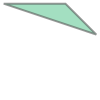

In [48]:
concave_hull